# generic

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from numba import njit, f8, i8, b1, optional

In [3]:
# Disable caching for performance testing
vbt.defaults.caching = False

In [4]:
index = pd.DatetimeIndex([
    datetime(2018, 1, 1),
    datetime(2018, 1, 2),
    datetime(2018, 1, 3),
    datetime(2018, 1, 4),
    datetime(2018, 1, 5)
], freq='D')
columns = ['a', 'b', 'c']
ts = pd.DataFrame({
    'a': [1, 2, 3, 4, np.nan], 
    'b': [np.nan, 4, 3, 2, 1],
    'c': [1, 2, np.nan, 2, 1]}, index=index).astype(np.float32)

print(ts)

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  NaN
2018-01-04  4.0  2.0  2.0
2018-01-05  NaN  1.0  1.0


In [5]:
big_ts = pd.DataFrame(np.random.randint(10, size=(1000, 1000)).astype(float))
big_ts.index = [datetime(2018, 1, 1) + timedelta(days=i) for i in range(1000)]
big_ts.shape

(1000, 1000)

In [6]:
# Test index frequency
print(ts.vbt.freq)
print(ts['a'].vbt.freq)
print(ts.vbt(freq='2D').freq)
print(ts['a'].vbt(freq='2D').freq)
print(pd.Series([1, 2, 3]).vbt.freq)
print(pd.Series([1, 2, 3]).vbt(freq='3D').freq)
print(pd.Series([1, 2, 3]).vbt(freq=np.timedelta64(4, 'D')).freq)

1 days 00:00:00
1 days 00:00:00
2 days 00:00:00
2 days 00:00:00
None
3 days 00:00:00
4 days 00:00:00


In [7]:
print(ts['a'].vbt.split_into_ranges(n=2))
%timeit big_ts.iloc[:, 0].vbt.split_into_ranges(n=100)

print(ts.vbt.split_into_ranges(n=2))
%timeit big_ts.vbt.split_into_ranges(n=100)

print(ts['a'].vbt.split_into_ranges(range_len=2))
%timeit big_ts.iloc[:, 0].vbt.split_into_ranges(range_len=100)

print(ts.vbt.split_into_ranges(range_len=2))
%timeit big_ts.vbt.split_into_ranges(range_len=100)

print(ts.vbt.split_into_ranges(start_idxs=[0, 1], end_idxs=[3, 4]))
print(ts.vbt.split_into_ranges(start_idxs=ts.index[[0, 1]], end_idxs=ts.index[[2, 3]]))

range_start 2018-01-01 2018-01-04
range_end   2018-01-02 2018-01-05
0                  1.0        4.0
1                  2.0        NaN
6.66 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                     a                     b                     c           
range_start 2018-01-01 2018-01-04 2018-01-01 2018-01-04 2018-01-01 2018-01-04
range_end   2018-01-02 2018-01-05 2018-01-02 2018-01-05 2018-01-02 2018-01-05
0                  1.0        4.0        NaN        2.0        1.0        2.0
1                  2.0        NaN        4.0        1.0        2.0        1.0
80.6 ms ± 18.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
range_start 2018-01-01 2018-01-02 2018-01-03 2018-01-04
range_end   2018-01-02 2018-01-03 2018-01-04 2018-01-05
0                  1.0        2.0        3.0        4.0
1                  2.0        3.0        4.0        NaN
14.4 ms ± 2.09 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
                     a                   

In [8]:
print(ts.fillna(-1))
%timeit big_ts.fillna(-1)

print(ts.vbt.fillna(-1))
%timeit big_ts.vbt.fillna(-1)

              a    b    c
2018-01-01  1.0 -1.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0 -1.0
2018-01-04  4.0  2.0  2.0
2018-01-05 -1.0  1.0  1.0
6.1 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  1.0 -1.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0 -1.0
2018-01-04  4.0  2.0  2.0
2018-01-05 -1.0  1.0  1.0
3.76 ms ± 178 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
print(ts.shift(3))
%timeit big_ts.shift(3)

print(ts.vbt.fshift(3))
%timeit big_ts.vbt.fshift(3)

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  NaN  NaN  NaN
2018-01-03  NaN  NaN  NaN
2018-01-04  1.0  NaN  1.0
2018-01-05  2.0  4.0  2.0
2.06 ms ± 38.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  NaN  NaN  NaN
2018-01-03  NaN  NaN  NaN
2018-01-04  1.0  NaN  1.0
2018-01-05  2.0  4.0  2.0
2.2 ms ± 79.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
print(ts.diff())
%timeit big_ts.diff()

print(ts.vbt.diff())
%timeit big_ts.vbt.diff()

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.0  NaN  1.0
2018-01-03  1.0 -1.0  NaN
2018-01-04  1.0 -1.0  NaN
2018-01-05  NaN -1.0 -1.0
4.38 ms ± 36.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.0  NaN  1.0
2018-01-03  1.0 -1.0  NaN
2018-01-04  1.0 -1.0  NaN
2018-01-05  NaN -1.0 -1.0
4.5 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
print(ts.pct_change(fill_method=None))
%timeit big_ts.pct_change(fill_method=None)

print(ts.vbt.pct_change())
%timeit big_ts.vbt.pct_change()

                   a         b    c
2018-01-01       NaN       NaN  NaN
2018-01-02  1.000000       NaN  1.0
2018-01-03  0.500000 -0.250000  NaN
2018-01-04  0.333333 -0.333333  NaN
2018-01-05       NaN -0.500000 -0.5
7.3 ms ± 196 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
                   a         b    c
2018-01-01       NaN       NaN  NaN
2018-01-02  1.000000       NaN  1.0
2018-01-03  0.500000 -0.250000  NaN
2018-01-04  0.333333 -0.333333  NaN
2018-01-05       NaN -0.500000 -0.5
4.91 ms ± 110 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
print(ts.ffill())
%timeit big_ts.ffill()

print(ts.vbt.ffill())
%timeit big_ts.vbt.ffill()

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  2.0
2018-01-04  4.0  2.0  2.0
2018-01-05  4.0  1.0  1.0
5.36 ms ± 58.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  2.0
2018-01-04  4.0  2.0  2.0
2018-01-05  4.0  1.0  1.0
7.73 ms ± 72.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
print(ts.product())
%timeit big_ts.product()

print(ts.vbt.product())
%timeit big_ts.vbt.product()

a    24.0
b    24.0
c     4.0
dtype: float32
6.87 ms ± 60.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    24.0
b    24.0
c     4.0
dtype: float64
3.17 ms ± 261 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
print(ts.cumsum())
%timeit big_ts.cumsum()

print(ts.vbt.cumsum())
%timeit big_ts.vbt.cumsum()

               a     b    c
2018-01-01   1.0   NaN  1.0
2018-01-02   3.0   4.0  3.0
2018-01-03   6.0   7.0  NaN
2018-01-04  10.0   9.0  5.0
2018-01-05   NaN  10.0  6.0
10.2 ms ± 79.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
               a     b    c
2018-01-01   1.0   NaN  1.0
2018-01-02   3.0   4.0  3.0
2018-01-03   6.0   7.0  NaN
2018-01-04  10.0   9.0  5.0
2018-01-05   NaN  10.0  6.0
8.57 ms ± 320 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
print(ts.cumprod())
%timeit big_ts.cumprod()

print(ts.vbt.cumprod())
%timeit big_ts.vbt.cumprod()

               a     b    c
2018-01-01   1.0   NaN  1.0
2018-01-02   2.0   4.0  2.0
2018-01-03   6.0  12.0  NaN
2018-01-04  24.0  24.0  4.0
2018-01-05   NaN  24.0  4.0
10.2 ms ± 84.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
               a     b    c
2018-01-01   1.0   NaN  1.0
2018-01-02   2.0   4.0  2.0
2018-01-03   6.0  12.0  NaN
2018-01-04  24.0  24.0  4.0
2018-01-05   NaN  24.0  4.0
8.25 ms ± 138 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
print(ts.rolling(2).min())
%timeit big_ts.rolling(2).min()

print(ts.vbt.rolling_min(2))
%timeit big_ts.vbt.rolling_min(2)

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.0  NaN  1.0
2018-01-03  2.0  3.0  NaN
2018-01-04  3.0  2.0  NaN
2018-01-05  NaN  1.0  1.0
56.2 ms ± 4.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.0  NaN  1.0
2018-01-03  2.0  3.0  NaN
2018-01-04  3.0  2.0  NaN
2018-01-05  NaN  1.0  1.0
13.8 ms ± 530 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
print(ts.rolling(2).max())
%timeit big_ts.rolling(2).max()

print(ts.vbt.rolling_max(2))
%timeit big_ts.vbt.rolling_max(2)

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  2.0  NaN  2.0
2018-01-03  3.0  4.0  NaN
2018-01-04  4.0  3.0  NaN
2018-01-05  NaN  2.0  2.0
54.5 ms ± 405 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  2.0  NaN  2.0
2018-01-03  3.0  4.0  NaN
2018-01-04  4.0  3.0  NaN
2018-01-05  NaN  2.0  2.0
13.2 ms ± 267 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
print(ts.rolling(2).mean())
%timeit big_ts.rolling(2).mean()

print(ts.vbt.rolling_mean(2))
%timeit big_ts.vbt.rolling_mean(2)

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.5  NaN  1.5
2018-01-03  2.5  3.5  NaN
2018-01-04  3.5  2.5  NaN
2018-01-05  NaN  1.5  1.5
47.5 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.5  NaN  1.5
2018-01-03  2.5  3.5  NaN
2018-01-04  3.5  2.5  NaN
2018-01-05  NaN  1.5  1.5
14.4 ms ± 535 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
print(ts.rolling(2).std())
%timeit big_ts.rolling(2).std()

print(ts.vbt.rolling_std(2))
%timeit big_ts.vbt.rolling_std(2)

                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  0.707107  0.707107       NaN
2018-01-04  0.707107  0.707107       NaN
2018-01-05       NaN  0.707107  0.707107
78.8 ms ± 3.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  0.707107  0.707107       NaN
2018-01-04  0.707107  0.707107       NaN
2018-01-05       NaN  0.707107  0.707107
17.3 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
print(ts.ewm(span=2).mean())
%timeit big_ts.ewm(span=2).mean()

print(ts.vbt.ewm_mean(2))
%timeit big_ts.vbt.ewm_mean(2)

                   a         b         c
2018-01-01  1.000000       NaN  1.000000
2018-01-02  1.750000  4.000000  1.750000
2018-01-03  2.615385  3.250000  1.750000
2018-01-04  3.550000  2.384615  1.967742
2018-01-05  3.550000  1.450000  1.267857
22.2 ms ± 744 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
                   a         b         c
2018-01-01  1.000000       NaN  1.000000
2018-01-02  1.750000  4.000000  1.750000
2018-01-03  2.615385  3.250000  1.750000
2018-01-04  3.550000  2.384615  1.967742
2018-01-05  3.550000  1.450000  1.267857
14.2 ms ± 827 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
print(ts.ewm(span=2).std())
%timeit big_ts.ewm(span=2).std()

print(ts.vbt.ewm_std(2))
%timeit big_ts.vbt.ewm_std(2)

                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  0.919866  0.707107  0.707107
2018-01-04  1.059753  0.919866  0.367607
2018-01-05  1.059753  1.059753  0.684914
36.8 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  0.919866  0.707107  0.707107
2018-01-04  1.059753  0.919866  0.367607
2018-01-05  1.059753  1.059753  0.684914
23.5 ms ± 348 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
print(ts.expanding().min())
%timeit big_ts.expanding().min()

print(ts.vbt.expanding_min())
%timeit big_ts.vbt.expanding_min()

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  1.0  4.0  1.0
2018-01-03  1.0  3.0  1.0
2018-01-04  1.0  2.0  1.0
2018-01-05  1.0  1.0  1.0
56.9 ms ± 496 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  1.0  4.0  1.0
2018-01-03  1.0  3.0  1.0
2018-01-04  1.0  2.0  1.0
2018-01-05  1.0  1.0  1.0
8.51 ms ± 308 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
print(ts.expanding().max())
%timeit big_ts.expanding().max()

print(ts.vbt.expanding_max())
%timeit big_ts.vbt.expanding_max()

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  4.0  2.0
2018-01-04  4.0  4.0  2.0
2018-01-05  4.0  4.0  2.0
57.3 ms ± 432 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  4.0  2.0
2018-01-04  4.0  4.0  2.0
2018-01-05  4.0  4.0  2.0
8.34 ms ± 93.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
print(ts.expanding().mean())
%timeit big_ts.expanding().mean()

print(ts.vbt.expanding_mean())
%timeit big_ts.vbt.expanding_mean()

              a    b         c
2018-01-01  1.0  NaN  1.000000
2018-01-02  1.5  4.0  1.500000
2018-01-03  2.0  3.5  1.500000
2018-01-04  2.5  3.0  1.666667
2018-01-05  2.5  2.5  1.500000
46.5 ms ± 561 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b         c
2018-01-01  1.0  NaN  1.000000
2018-01-02  1.5  4.0  1.500000
2018-01-03  2.0  3.5  1.500000
2018-01-04  2.5  3.0  1.666667
2018-01-05  2.5  2.5  1.500000
14.4 ms ± 776 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
print(ts.expanding().std())
%timeit big_ts.expanding().std()

print(ts.vbt.expanding_std())
%timeit big_ts.vbt.expanding_std()

                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  1.000000  0.707107  0.707107
2018-01-04  1.290994  1.000000  0.577350
2018-01-05  1.290994  1.290994  0.577350
78.4 ms ± 713 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  1.000000  0.707107  0.707107
2018-01-04  1.290994  1.000000  0.577350
2018-01-05  1.290994  1.290994  0.577350
16.5 ms ± 180 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
pd_nanmean_nb = njit(lambda x: np.nanmean(x))
nanmean_nb = njit(lambda col, i, x: np.nanmean(x))
nanmean_matrix_nb = njit(lambda i, x: np.nanmean(x))

In [27]:
print(ts.rolling(2, min_periods=1).apply(pd_nanmean_nb, raw=True))
%timeit big_ts.rolling(2, min_periods=1).apply(pd_nanmean_nb, raw=True)

print(ts.vbt.rolling_apply(2, nanmean_nb))
%timeit big_ts.vbt.rolling_apply(2, nanmean_nb)

print(ts.vbt.rolling_apply(3, nanmean_matrix_nb, on_matrix=True))
%timeit big_ts.vbt.rolling_apply(3, nanmean_matrix_nb, on_matrix=True)

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  1.5  4.0  1.5
2018-01-03  2.5  3.5  2.0
2018-01-04  3.5  2.5  2.0
2018-01-05  4.0  1.5  1.5
644 ms ± 5.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  1.5  4.0  1.5
2018-01-03  2.5  3.5  2.0
2018-01-04  3.5  2.5  2.0
2018-01-05  4.0  1.5  1.5
47.5 ms ± 541 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b         c
2018-01-01  1.000000  1.000000  1.000000
2018-01-02  2.000000  2.000000  2.000000
2018-01-03  2.285714  2.285714  2.285714
2018-01-04  2.750000  2.750000  2.750000
2018-01-05  2.285714  2.285714  2.285714
6.62 ms ± 57.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
print(ts.expanding(min_periods=1).apply(pd_nanmean_nb, raw=True))
%timeit big_ts.expanding(min_periods=1).apply(pd_nanmean_nb, raw=True)

print(ts.vbt.expanding_apply(nanmean_nb))
%timeit big_ts.vbt.expanding_apply(nanmean_nb)

print(ts.vbt.expanding_apply(nanmean_matrix_nb, on_matrix=True))
%timeit big_ts.vbt.expanding_apply(nanmean_matrix_nb, on_matrix=True)

              a    b         c
2018-01-01  1.0  NaN  1.000000
2018-01-02  1.5  4.0  1.500000
2018-01-03  2.0  3.5  1.500000
2018-01-04  2.5  3.0  1.666667
2018-01-05  2.5  2.5  1.500000
1.42 s ± 6.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b         c
2018-01-01  1.0  NaN  1.000000
2018-01-02  1.5  4.0  1.500000
2018-01-03  2.0  3.5  1.500000
2018-01-04  2.5  3.0  1.666667
2018-01-05  2.5  2.5  1.500000
843 ms ± 17.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b         c
2018-01-01  1.000000  1.000000  1.000000
2018-01-02  2.000000  2.000000  2.000000
2018-01-03  2.285714  2.285714  2.285714
2018-01-04  2.400000  2.400000  2.400000
2018-01-05  2.166667  2.166667  2.166667
818 ms ± 6.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
print(ts['a'].groupby(np.asarray([1, 1, 2, 2, 3])).apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.iloc[:, 0].groupby(np.random.randint(10, size=1000)).apply(lambda x: pd_nanmean_nb(x.values))

print(ts['a'].vbt.groupby_apply(np.asarray([1, 1, 2, 2, 3]), nanmean_nb))
%timeit big_ts.iloc[:, 0].vbt.groupby_apply(np.random.randint(10, size=1000), nanmean_nb)

print(ts.groupby(np.asarray([1, 1, 2, 2, 3])).agg({
    'a': lambda x: pd_nanmean_nb(x.values), 
    'b': lambda x: pd_nanmean_nb(x.values), 
    'c': lambda x: pd_nanmean_nb(x.values)})) # any clean way to do column-wise grouping in pandas?

print(ts.vbt.groupby_apply(np.asarray([1, 1, 2, 2, 3]), nanmean_nb))
%timeit big_ts.vbt.groupby_apply(np.random.randint(10, size=1000), nanmean_nb)

print(ts.vbt.groupby_apply(np.asarray([1, 1, 2, 2, 3]), nanmean_matrix_nb, on_matrix=True))
%timeit big_ts.vbt.groupby_apply(np.random.randint(10, size=1000), nanmean_matrix_nb, on_matrix=True)

1    1.5
2    3.5
3    NaN
Name: a, dtype: float64
1.63 ms ± 8.97 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1    1.5
2    3.5
3    NaN
Name: a, dtype: float64
1.32 ms ± 147 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
     a    b    c
1  1.5  4.0  1.5
2  3.5  2.5  2.0
3  NaN  1.0  1.0
     a    b    c
1  1.5  4.0  1.5
2  3.5  2.5  2.0
3  NaN  1.0  1.0
8.02 ms ± 256 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
     a    b    c
1  2.0  2.0  2.0
2  2.8  2.8  2.8
3  1.0  1.0  1.0
3.66 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
print(ts['a'].resample('1h').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.iloc[:, 0].resample('1h').apply(lambda x: pd_nanmean_nb(x.values))

print(ts['a'].vbt.resample_apply('1h', nanmean_nb))
%timeit big_ts.iloc[:, 0].vbt.resample_apply('1h', nanmean_nb)

print(ts.resample('1h').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.iloc[:, :100].resample('1h').apply(lambda x: pd_nanmean_nb(x.values))

print(ts.vbt.resample_apply('1h', nanmean_nb))
%timeit big_ts.vbt.resample_apply('1h', nanmean_nb)

print(ts.vbt.resample_apply('1h', nanmean_matrix_nb, on_matrix=True))
%timeit big_ts.vbt.resample_apply('1h', nanmean_matrix_nb, on_matrix=True)

2018-01-01 00:00:00    1.0
2018-01-01 01:00:00    NaN
2018-01-01 02:00:00    NaN
2018-01-01 03:00:00    NaN
2018-01-01 04:00:00    NaN
                      ... 
2018-01-04 20:00:00    NaN
2018-01-04 21:00:00    NaN
2018-01-04 22:00:00    NaN
2018-01-04 23:00:00    NaN
2018-01-05 00:00:00    NaN
Freq: H, Name: a, Length: 97, dtype: float32
178 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2018-01-01 00:00:00    1.0
2018-01-01 01:00:00    NaN
2018-01-01 02:00:00    NaN
2018-01-01 03:00:00    NaN
2018-01-01 04:00:00    NaN
                      ... 
2018-01-04 20:00:00    NaN
2018-01-04 21:00:00    NaN
2018-01-04 22:00:00    NaN
2018-01-04 23:00:00    NaN
2018-01-05 00:00:00    NaN
Freq: H, Name: a, Length: 97, dtype: float64
66.6 ms ± 924 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
                       a    b    c
2018-01-01 00:00:00  1.0  NaN  1.0
2018-01-01 01:00:00  NaN  NaN  NaN
2018-01-01 02:00:00  NaN  NaN  NaN
2018-01-01 03:00:00  NaN  NaN  NaN
2

In [31]:
print(ts['a'].resample('3d').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.iloc[:, 0].resample('3d').apply(lambda x: pd_nanmean_nb(x.values))

print(ts['a'].vbt.resample_apply('3d', nanmean_nb))
%timeit big_ts.iloc[:, 0].vbt.resample_apply('3d', nanmean_nb)

print(ts.resample('3d').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.resample('3d').apply(lambda x: pd_nanmean_nb(x.values))

print(ts.vbt.resample_apply('3d', nanmean_nb))
%timeit big_ts.vbt.resample_apply('3d', nanmean_nb)

print(ts.vbt.resample_apply('3d', nanmean_matrix_nb, on_matrix=True))
%timeit big_ts.vbt.resample_apply('3d', nanmean_matrix_nb, on_matrix=True)

2018-01-01    2.0
2018-01-04    4.0
Freq: 3D, Name: a, dtype: float32
3.28 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2018-01-01    2.0
2018-01-04    4.0
Freq: 3D, Name: a, dtype: float64
6.25 ms ± 60 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  2.0  3.5  1.5
2018-01-04  4.0  1.5  1.5
3.27 s ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b    c
2018-01-01  2.0  3.5  1.5
2018-01-04  4.0  1.5  1.5
83.2 ms ± 2.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
                   a         b         c
2018-01-01  2.285714  2.285714  2.285714
2018-01-04  2.000000  2.000000  2.000000
10.7 ms ± 53.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
print(ts['a'].resample('1w').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.iloc[:, 0].resample('1w').apply(lambda x: pd_nanmean_nb(x.values))

print(ts['a'].vbt.resample_apply('1w', nanmean_nb))
%timeit big_ts.iloc[:, 0].vbt.resample_apply('1w', nanmean_nb)

print(ts.resample('1w').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.resample('1w').apply(lambda x: pd_nanmean_nb(x.values))

print(ts.vbt.resample_apply('1w', nanmean_nb))
%timeit big_ts.vbt.resample_apply('1w', nanmean_nb)

print(ts.vbt.resample_apply('1w', nanmean_matrix_nb, on_matrix=True))
%timeit big_ts.vbt.resample_apply('1w', nanmean_matrix_nb, on_matrix=True)

2018-01-07    2.5
Freq: W-SUN, Name: a, dtype: float32
4.12 ms ± 56.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2018-01-07    2.5
Freq: W-SUN, Name: a, dtype: float64
6.42 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-07  2.5  2.5  1.5
2.23 s ± 34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b    c
2018-01-07  2.5  2.5  1.5
39.1 ms ± 416 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
                   a         b         c
2018-01-07  2.166667  2.166667  2.166667
9.13 ms ± 59.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
mult_nb = njit(lambda col, i, x: x * 2)

print(ts.applymap(lambda x: x * 2))
%timeit big_ts.applymap(lambda x: x * 2)

print(ts['a'].vbt.applymap(mult_nb))
%timeit big_ts.iloc[:, 0].vbt.applymap(mult_nb)

print(ts.vbt.applymap(mult_nb))
%timeit big_ts.vbt.applymap(mult_nb)

              a    b    c
2018-01-01  2.0  NaN  2.0
2018-01-02  4.0  8.0  4.0
2018-01-03  6.0  6.0  NaN
2018-01-04  8.0  4.0  4.0
2018-01-05  NaN  2.0  2.0
420 ms ± 8.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2018-01-01    2.0
2018-01-02    4.0
2018-01-03    6.0
2018-01-04    8.0
2018-01-05    NaN
Freq: D, Name: a, dtype: float64
612 µs ± 106 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b    c
2018-01-01  2.0  NaN  2.0
2018-01-02  4.0  8.0  4.0
2018-01-03  6.0  6.0  NaN
2018-01-04  8.0  4.0  4.0
2018-01-05  NaN  2.0  2.0
10.8 ms ± 248 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
greater_nb = njit(lambda col, i, x: x > 2)

print(ts.applymap(lambda x: x if x > 2 else np.nan))
%timeit big_ts.applymap(lambda x: x if x > 2 else np.nan)

print(ts['a'].vbt.filter(greater_nb))
%timeit big_ts.iloc[:, 0].vbt.filter(greater_nb)

print(ts.vbt.filter(greater_nb))
%timeit big_ts.vbt.filter(greater_nb)

              a    b   c
2018-01-01  NaN  NaN NaN
2018-01-02  NaN  4.0 NaN
2018-01-03  3.0  3.0 NaN
2018-01-04  4.0  NaN NaN
2018-01-05  NaN  NaN NaN
446 ms ± 8.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2018-01-01    NaN
2018-01-02    NaN
2018-01-03    3.0
2018-01-04    4.0
2018-01-05    NaN
Freq: D, Name: a, dtype: float64
636 µs ± 114 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b   c
2018-01-01  NaN  NaN NaN
2018-01-02  NaN  4.0 NaN
2018-01-03  3.0  3.0 NaN
2018-01-04  4.0  NaN NaN
2018-01-05  NaN  NaN NaN
12.4 ms ± 635 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
every_2th_nb = njit(lambda col, a: a[::2])
sum_nb = njit(lambda col, a: np.nansum(a))

print(ts['a'].vbt.apply_and_reduce(every_2th_nb, sum_nb))
%timeit big_ts.iloc[:, 0].vbt.apply_and_reduce(every_2th_nb, sum_nb)

print(ts.vbt.apply_and_reduce(every_2th_nb, sum_nb))
%timeit big_ts.vbt.apply_and_reduce(every_2th_nb, sum_nb)

print(ts.vbt.apply_and_reduce(every_2th_nb, sum_nb, time_units=True))
%timeit big_ts.vbt.apply_and_reduce(every_2th_nb, sum_nb, time_units=True)

4.0
541 µs ± 95.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
a    4.0
b    4.0
c    2.0
dtype: float64
1.57 ms ± 43.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
a   4 days
b   4 days
c   2 days
dtype: timedelta64[ns]
1.84 ms ± 29.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [36]:
print(ts.apply(np.nansum, axis=0))
%timeit big_ts.apply(np.nansum, axis=0)

print(ts['a'].vbt.reduce(sum_nb))
%timeit big_ts.iloc[:, 0].vbt.reduce(sum_nb)

print(ts.vbt.reduce(sum_nb))
%timeit big_ts.vbt.reduce(sum_nb)

print(ts.vbt.reduce(sum_nb, time_units=True))
%timeit big_ts.vbt.reduce(sum_nb, time_units=True)

a    10.0
b    10.0
c     6.0
dtype: float64
63.3 ms ± 492 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
10.0
470 µs ± 4.18 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
a    10.0
b    10.0
c     6.0
dtype: float64
3.13 ms ± 47.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   10 days
b   10 days
c    6 days
dtype: timedelta64[ns]
3.25 ms ± 32.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
@njit
def min_and_max_nb(col, a):
    result = np.empty(2)
    result[0] = np.nanmin(a)
    result[1] = np.nanmax(a)
    return result

print(ts.apply(lambda x: np.asarray([np.min(x), np.max(x)]), axis=0))
%timeit big_ts.apply(lambda x: np.asarray([np.min(x), np.max(x)]), axis=0)

print(ts['a'].vbt.reduce_to_array(min_and_max_nb, index=['min', 'max']))
%timeit big_ts.iloc[:, 0].vbt.reduce_to_array(min_and_max_nb, index=['min', 'max'])

print(ts.vbt.reduce_to_array(min_and_max_nb, index=['min', 'max']))
%timeit big_ts.vbt.reduce_to_array(min_and_max_nb, index=['min', 'max'])

print(ts.vbt.reduce_to_array(min_and_max_nb, index=['min', 'max'], time_units=True))
%timeit big_ts.vbt.reduce_to_array(min_and_max_nb, index=['min', 'max'], time_units=True)

     a    b    c
0  1.0  1.0  1.0
1  4.0  4.0  2.0
154 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
min    1.0
max    4.0
Name: a, dtype: float64
774 µs ± 158 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
       a    b    c
min  1.0  1.0  1.0
max  4.0  4.0  2.0
5.06 ms ± 69.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
         a      b      c
min 1 days 1 days 1 days
max 4 days 4 days 2 days
5.32 ms ± 52.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
print(ts.min())
%timeit big_ts.min()

print(ts.vbt.min())
%timeit big_ts.vbt.min()

print(ts.vbt.min(time_units=True))
%timeit big_ts.vbt.min(time_units=True)

a    1.0
b    1.0
c    1.0
dtype: float32
5.91 ms ± 70.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    1.0
b    1.0
c    1.0
dtype: float32
4.02 ms ± 192 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   1 days
b   1 days
c   1 days
dtype: timedelta64[ns]
3.94 ms ± 42.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
print(ts.max())
%timeit big_ts.max()

print(ts.vbt.max())
%timeit big_ts.vbt.max()

print(ts.vbt.max(time_units=True))
%timeit big_ts.vbt.max(time_units=True)

a    4.0
b    4.0
c    2.0
dtype: float32
5.91 ms ± 56.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    4.0
b    4.0
c    2.0
dtype: float32
3.86 ms ± 80.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   4 days
b   4 days
c   2 days
dtype: timedelta64[ns]
4.06 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [40]:
print(ts.mean())
%timeit big_ts.mean()

print(ts.vbt.mean())
%timeit big_ts.vbt.mean()

print(ts.vbt.mean(time_units=True))
%timeit big_ts.vbt.mean(time_units=True)

a    2.5
b    2.5
c    1.5
dtype: float32
5.03 ms ± 76.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    2.5
b    2.5
c    1.5
dtype: float32
2.86 ms ± 30.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   2 days 12:00:00
b   2 days 12:00:00
c   1 days 12:00:00
dtype: timedelta64[ns]
2.92 ms ± 31.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
print(ts.std())
%timeit big_ts.std()

print(ts.vbt.std())
%timeit big_ts.vbt.std()

print(ts.vbt.std(time_units=True))
%timeit big_ts.vbt.std(time_units=True)

a    1.290994
b    1.290994
c    0.577350
dtype: float32
6.09 ms ± 88.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    1.290994
b    1.290994
c    0.577350
dtype: float32
3.94 ms ± 43.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   1 days 06:59:01.916656494
b   1 days 06:59:01.916656494
c   0 days 13:51:23.062362670
dtype: timedelta64[ns]
4.01 ms ± 44.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
print((~ts.isnull()).sum())
%timeit (~big_ts.isnull()).sum()

print(ts.vbt.count())
%timeit big_ts.vbt.count()

print(ts.vbt.count(time_units=True))
%timeit big_ts.vbt.count(time_units=True)

a    4
b    4
c    4
dtype: int64
4.52 ms ± 50.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    4
b    4
c    4
dtype: int64
2.01 ms ± 80.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
a   4 days
b   4 days
c   4 days
dtype: timedelta64[ns]
2.06 ms ± 35.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [43]:
print(ts.idxmin())
%timeit big_ts.idxmin()

print(ts.vbt.idxmin())
%timeit big_ts.vbt.idxmin()

a   2018-01-01
b   2018-01-05
c   2018-01-01
dtype: datetime64[ns]
20.9 ms ± 811 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
a   2018-01-01
b   2018-01-05
c   2018-01-01
dtype: datetime64[ns]
8.68 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [44]:
print(ts.idxmax())
%timeit big_ts.idxmax()

print(ts.vbt.idxmax())
%timeit big_ts.vbt.idxmax()

a   2018-01-04
b   2018-01-02
c   2018-01-02
dtype: datetime64[ns]
20.5 ms ± 176 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
a   2018-01-04
b   2018-01-02
c   2018-01-02
dtype: datetime64[ns]
8.68 ms ± 178 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [45]:
print(ts.describe(percentiles=np.arange(0, 1, 0.1)))
%timeit big_ts.describe(percentiles=np.arange(0, 1, 0.1))

print(ts.vbt.describe(percentiles=np.arange(0, 1, 0.1)))
%timeit big_ts.vbt.describe(percentiles=np.arange(0, 1, 0.1))

              a         b        c
count  4.000000  4.000000  4.00000
mean   2.500000  2.500000  1.50000
std    1.290994  1.290994  0.57735
min    1.000000  1.000000  1.00000
0%     1.000000  1.000000  1.00000
10%    1.300000  1.300000  1.00000
20%    1.600000  1.600000  1.00000
30%    1.900000  1.900000  1.00000
40%    2.200000  2.200000  1.20000
50%    2.500000  2.500000  1.50000
60%    2.800000  2.800000  1.80000
70%    3.100000  3.100000  2.00000
80%    3.400000  3.400000  2.00000
90%    3.700000  3.700000  2.00000
max    4.000000  4.000000  2.00000
1.75 s ± 11.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a         b        c
count  4.000000  4.000000  4.00000
mean   2.500000  2.500000  1.50000
std    1.290994  1.290994  0.57735
min    1.000000  1.000000  1.00000
0%     1.000000  1.000000  1.00000
10%    1.300000  1.300000  1.00000
20%    1.600000  1.600000  1.00000
30%    1.900000  1.900000  1.00000
40%    2.200000  2.200000  1.20000
50%    2.500000  2.500

In [46]:
print(ts / ts.expanding().max() - 1)
%timeit big_ts / big_ts.expanding().max()

print(ts.vbt.drawdown())
%timeit big_ts.vbt.drawdown()

              a     b    c
2018-01-01  0.0   NaN  0.0
2018-01-02  0.0  0.00  0.0
2018-01-03  0.0 -0.25  NaN
2018-01-04  0.0 -0.50  0.0
2018-01-05  NaN -0.75 -0.5
60.4 ms ± 494 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a     b    c
2018-01-01  0.0   NaN  0.0
2018-01-02  0.0  0.00  0.0
2018-01-03  0.0 -0.25  NaN
2018-01-04  0.0 -0.50  0.0
2018-01-05  NaN -0.75 -0.5
11.9 ms ± 149 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/generic/accessors.py:546: RuntimeWarning: invalid value encountered in true_divide
  return self.wrap(self.to_2d_array() / nb.expanding_max_nb(self.to_2d_array()) - 1)


In [47]:
print(ts.vbt.drawdowns())
%timeit big_ts.vbt.drawdowns()

8 ms ± 89.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


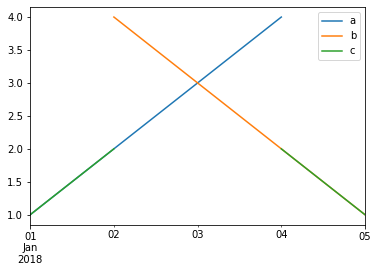

In [48]:
# Two ways of plotting
ts.plot()

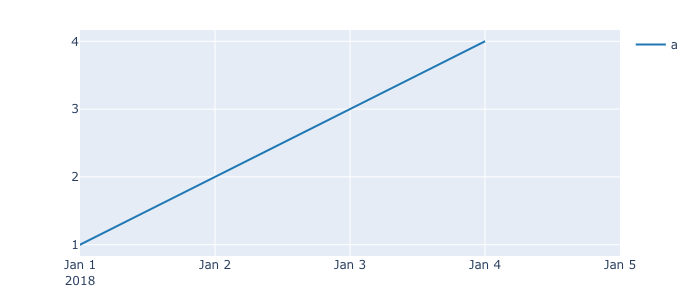

In [49]:
ts['a'].vbt.plot().show_png()

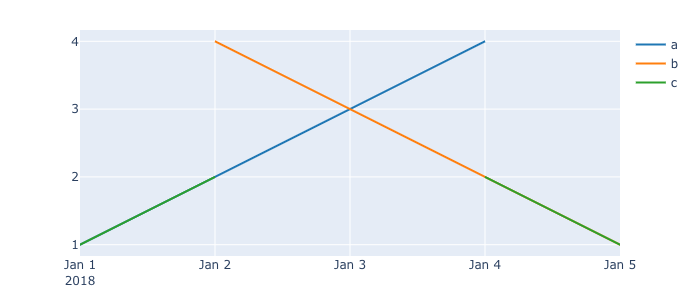

In [50]:
ts.vbt.plot().show_png()